In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'
! echo $OMP_NUM_THREADS

40


In [2]:
import nawrapper as nw
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits

In [3]:
planck_project = '/tigress/zequnl/cmb/software/PSpipe/project/Planck/'

In [82]:
lmax = 2508
project_dir = '/tigress/zequnl/cmb/data/planck2018/'
map_dir = f'{project_dir}/maps/PR3/frequencyMaps'
mask_dir = f'{project_dir}/maps/PR3/maskMaps/'
beam_dir = f'{project_dir}/BeamWf_HFI_R3.01/'
freq1, freq2 = '143', '217'

m1, m2 = nw.planck.get_half_mission_namap(
    freq1, freq2, map_dir, mask_dir, beam_dir)

{'pol_efficiency': {'100': 0.9995, '143': 0.999, '217': 0.999}, 'nside': 2048, 'lmax': 2508}
Creating a healpix namap. temperature: True, polarization: True
Including the healpix pixel window function.
Computing spherical harmonics.

Creating a healpix namap. temperature: True, polarization: True
Including the healpix pixel window function.
Computing spherical harmonics.



In [83]:
bins = nw.create_binning(lmax)

mcm_string = f'/tigress/zequnl/cmb/data/mcm/planck/{freq1}x{freq2}'
mc_11 = nw.mode_coupling(m1, m1, bins=bins, mcm_dir=f'{mcm_string}_11')
mc_12 = nw.mode_coupling(m1, m2, bins=bins, mcm_dir=f'{mcm_string}_12')
mc_22 = nw.mode_coupling(m2, m2, bins=bins, mcm_dir=f'{mcm_string}_22')

Loading mode-coupling matrices from disk.
Loading mode-coupling matrices from disk.
Loading mode-coupling matrices from disk.


In [84]:
# for freq1, freq2 in ( ('100', '100'), ('100', '143'), ('100', '217'), ('143', '143'), ('143', '217'), ('217', '217') ):
    
#     m1, m2 = nw.planck.get_half_mission_namap(
#         freq1, freq2, map_dir, mask_dir, beam_dir)
    
#     mcm_string = f'/tigress/zequnl/cmb/data/mcm/planck/{freq1}x{freq2}'
#     mc_11 = nw.mode_coupling(m1, m1, bins=bins, mcm_dir=f'{mcm_string}_11')
#     mc_12 = nw.mode_coupling(m1, m2, bins=bins, mcm_dir=f'{mcm_string}_12')
#     mc_22 = nw.mode_coupling(m2, m2, bins=bins, mcm_dir=f'{mcm_string}_22')

In [85]:
binleft, binright = np.genfromtxt(
    '/tigress/zequnl/cmb/software/PSpipe/project/Planck/planck_spectra/binused.dat',
    unpack=True, usecols=(0,1), dtype=((int), (int)))
Cl12 = nw.compute_spectra(m1, m2, mc=mc_12)
Cb = nw.bin_spec_dict(Cl12, binleft, binright, lmax)

TT_143x217 335 550
None 335 550
TE_143x217 2009 2149
None 2009 2149
EE_143x217 1247 1387
None 1247 1387


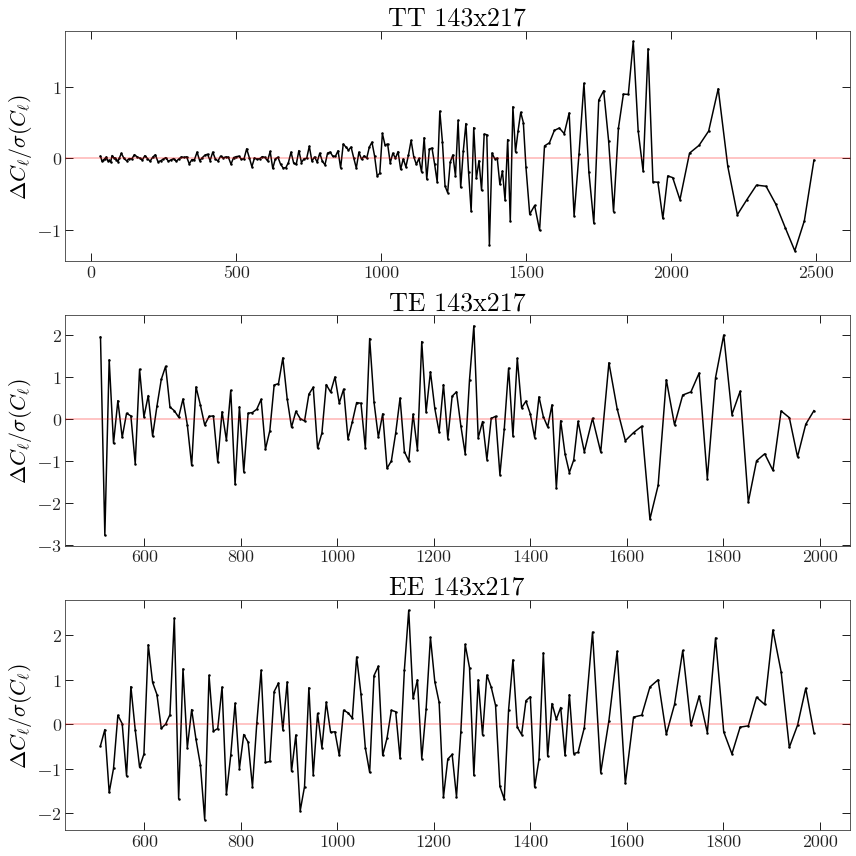

In [86]:
pl = nw.planck.PlanckCov(
    ellspath=f'{planck_project}/planck_spectra/vec_all_spectra.dat',
    clpath='data/planck/data_extracted.dat',
    covpath='data/planck/covmat.dat'
    )

fig, axes = plt.subplots(3,1,figsize=(12,12))
for ax, spec in zip(axes, ['TT', 'TE', 'EE']):
    lb = Cb['ell']
    
    ell, cl, err, _  = pl.get_spec(f'{spec}_{freq1}x{freq2}')
    subcov  = pl.get_subcov(
        f'{spec}_{freq1}x{freq2}')
    dl_ref_fac = ell*(ell+1)/(2*np.pi)
    ref_filt = np.in1d(lb, ell)
    if spec == 'TE':
        diy_spec = (Cb['TE'][ref_filt] + Cb['ET'][ref_filt])/ 2.0
    else:
        diy_spec = Cb[spec][ref_filt]
    ax.plot(ell, (diy_spec - (cl)) / (err), 'k.-', label=spec)
    ax.axhline(0, color='red', alpha=0.3)
    ax.set_ylabel(r'$\Delta C_{\ell} / \sigma(C_{\ell})$')
    ax.set_title(f'{spec} {freq1}x{freq2}')
plt.tight_layout()

In [87]:
cov = nw.nacov(m1, m2, mc_11=mc_11, mc_12=mc_12, mc_22=mc_22)

In [88]:
%%time
cov.compute()

CPU times: user 2h 21min 31s, sys: 4min 38s, total: 2h 26min 10s
Wall time: 3min 46s


In [89]:
cov_plic  = pl.get_subcov(
    f'TE_{freq1}x{freq2}', f'EE_{freq1}x{freq2}')
ell_cov, cl, err, _  = pl.get_spec(f'TE_{freq1}x{freq2}')

TE_143x217 2009 2149
EE_143x217 1247 1387


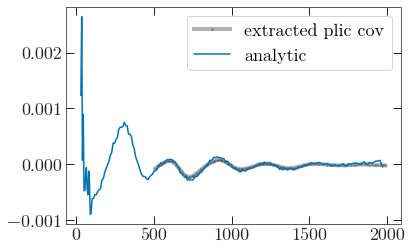

In [92]:
ell_sub_list = [np.arange(l, r) for (l, r) in zip(binleft, binright+1)]

binned_cov = np.zeros((len(ell_sub_list), len(ell_sub_list)))
lb = np.array([ (l+r)/2.0 for l,r in zip(binleft, binright) ])
for i, (bin_i) in enumerate( zip(binleft, binright+1) ):
    for j, (bin_j) in enumerate( zip(binleft, binright+1) ):
        binned_cov[i,j] = np.mean( cov.covmat['TEEE'][bin_i[0]:bin_i[1], bin_j[0]:bin_j[1]] )

plt.plot( ell_cov, (np.diag(cov_plic)) * ell_cov**2, label="extracted plic cov",
        lw=4, alpha=0.3)

plt.plot(lb[lb < ell_cov[-1]], 
         ((np.diag(binned_cov)) * lb**2)[lb < ell_cov[-1]], 
         '-', label='analytic', markersize=0)

plt.legend()
